In [57]:
import pandas as pd
from datetime import datetime
from datetime import timedelta
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statistics as stats
from tqdm import tqdm
from time import time
from numpy.random import choice

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AgglomerativeClustering
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_validate
from sklearn.ensemble import VotingClassifier
import xgboost as xgb
import shap

In [104]:
sns.set(rc={'figure.figsize':(16,9)})

In [2]:
df1 = pd.read_csv('dataset_sales_2.csv', sep = ';')

In [514]:
df1.head()

,date_order,date_invoice,product_id,client_id,sales_net,quantity,order_channel,branch_id
0,2017-09-25,2017-09-25,2376333,188502,155.44320,3,online,2732
1,2017-09-25,2017-09-25,2520527,835089,16.39440,3,at the store,10279
2,2017-09-25,2017-09-25,2536756,1977896,365.76624,21,online,6184
3,2017-09-25,2017-09-25,3028673,598816,8.59878,201,at the store,4200
4,2017-09-25,2017-09-25,203377,2086861,1093.37400,3,by phone,7051


In [27]:
#Convert date from string to datetime
df1['date_order'] = df1['date_order'].apply(lambda x : datetime.strptime(x, '%Y-%m-%d'))

In [ ]:
#df1['date_invoice'] = df1['date_invoice'].apply(lambda x : datetime.strptime(x, '%Y-%m-%d'))

## Data Exploration

In [257]:
df2 = df1[df1['sales_net'] > 0].copy()

### Missing values

In [6]:
#Checking missing values
missing_df = df1.isna()
missing_df = np.round(100 * missing_df.sum()/len(df1), 2)
missing_df

date_order       0.0
date_invoice     0.0
product_id       0.0
client_id        0.0
sales_net        0.0
quantity         0.0
order_channel    0.0
branch_id        0.0
dtype: float64

### Sales_net & Quantity

In [49]:
#Sales-net and quantity
df1[['sales_net', 'quantity']].describe()

,sales_net,quantity
count,6.331932e+07,6.331932e+07
mean,1.479416e+02,9.215658e+01
std,8.646548e+02,8.674801e+02
min,-1.738817e+06,3.000000e+00
25%,1.414653e+01,3.000000e+00
50%,4.424280e+01,5.000000e+00
75%,1.314680e+02,2.100000e+01
max,1.740456e+06,1.980010e+05


In [ ]:
sns.histplot(data=df1, x="sales_net")

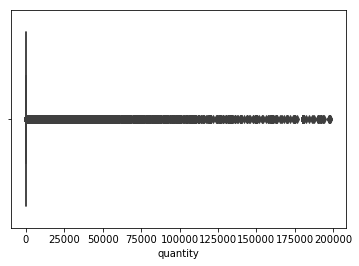

In [55]:
ax = sns.boxplot(x=df1["quantity"])

### Channel and Branch

In [57]:
df1['order_channel'].nunique()

5

In [59]:
df1['branch_id'].nunique()

582

### Products

In [61]:
df1['product_id'].nunique()

607418

### Clients

In [62]:
df1['client_id'].nunique()

170589

## 2018 figures

In [466]:
df2018 = df1[df1.date_order.apply(lambda x : x.year) == 2018]

In [468]:
df2018[df2018.sales_net > 0].sales_net.sum()

4916907466.33335

In [469]:
df2018.client_id.nunique()

142951

In [472]:
df2018.order_channel.value_counts()

at the store                       16125162
by phone                           12793815
online                              2719111
other                                 29176
during the visit of a sales rep       14199
Name: order_channel, dtype: int64

### Inter-dependecies

In [63]:
#Nb of branches per channel
df1.groupby(['order_channel']).agg({'branch_id' : 'nunique'})

,branch_id
order_channel,
at the store,555
by phone,572
during the visit of a sales rep,142
online,510
other,478


In [64]:
#Nb of products per customers
df_gby = df1.groupby(['client_id']).agg({'product_id' : 'nunique'}).reset_index()
df_gby.groupby(['product_id']).agg({'client_id' : 'nunique'})

,client_id
product_id,
1,8153
2,7722
3,5773
4,4968
5,4489
...,...
9999,1
10251,1
10465,1


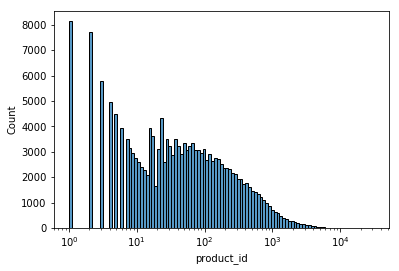

In [66]:
sns.histplot(data=df_gby, x="product_id", log_scale = True)

In [81]:
#Time series 
df_monthly = df1.copy()
df_monthly['year_month'] = df_monthly['date_order'].apply(lambda x : str(x.year) + '_' + str(x.month))

In [82]:
df_monthly_gby = df_monthly.groupby(['year_month']).agg({'sales_net' : 'sum', 'quantity' : 'sum', 'client_id' : 'nunique', 'product_id' : 'nunique'}).reset_index()

In [85]:
df_monthly_gby

,year_month,sales_net,quantity,client_id,product_id
0,2017_10,4.188312e+08,302317615,76486,113890
1,2017_11,4.025142e+08,250233470,74598,113154
2,2017_12,3.721120e+08,233447497,71944,108477
3,2017_9,8.862928e+07,55969046,39862,53279
4,2018_1,3.882355e+08,243431506,72215,110508
5,2018_10,4.408281e+08,286163151,76151,116149
6,2018_11,4.031602e+08,252437569,73367,113221
7,2018_12,4.071132e+08,278901278,72572,112997
8,2018_2,3.697512e+08,232455180,70199,107465
9,2018_3,4.317772e+08,271642534,73580,116247


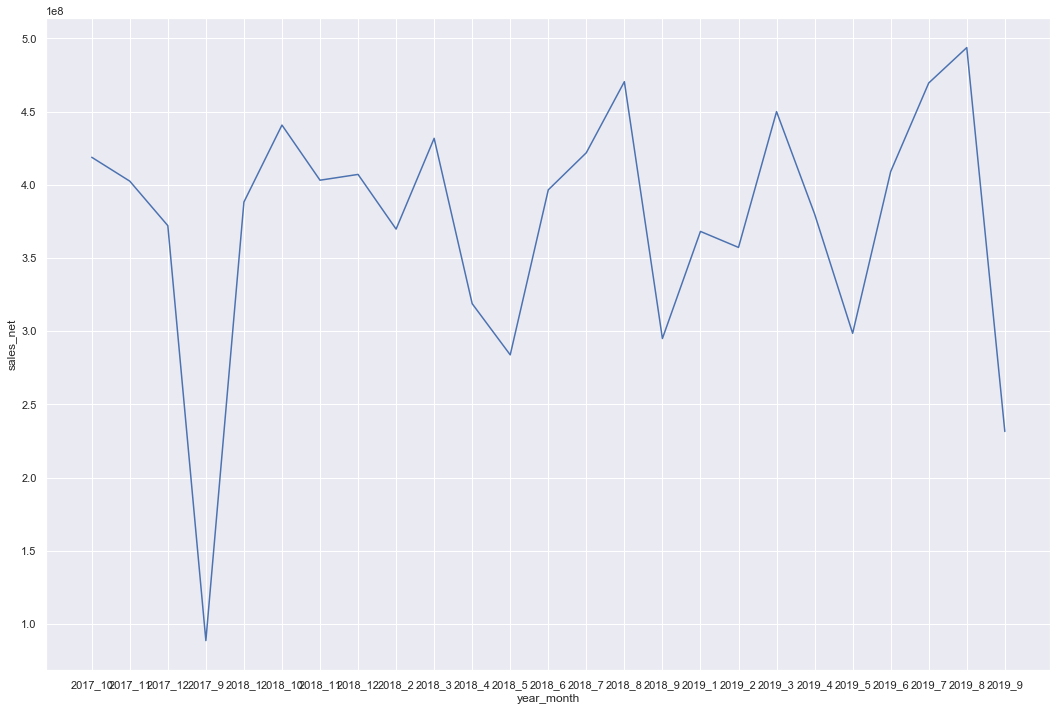

In [113]:
sns.set(rc={'figure.figsize':(18,12)})
sns.lineplot(data = df_monthly_gby, x = 'year_month', y = 'sales_net')

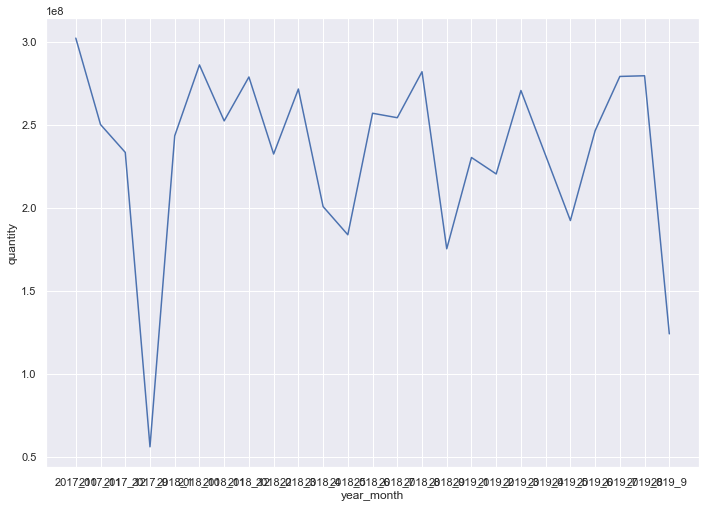

In [89]:
sns.lineplot(data = df_monthly_gby, x = 'year_month', y = 'quantity')

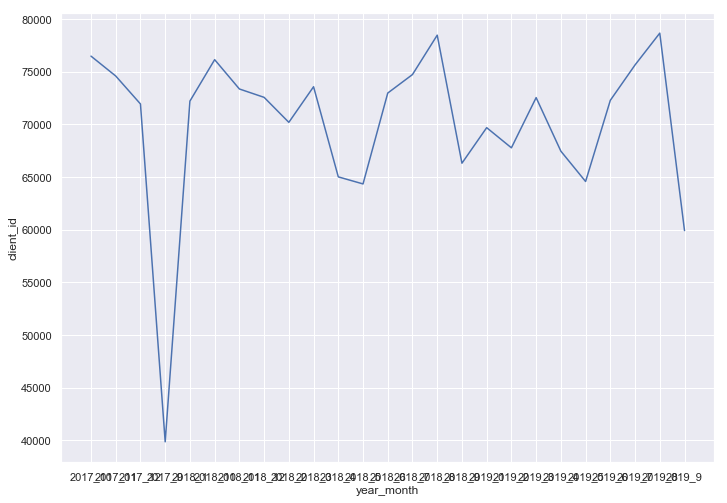

In [90]:
sns.lineplot(data = df_monthly_gby, x = 'year_month', y = 'client_id')

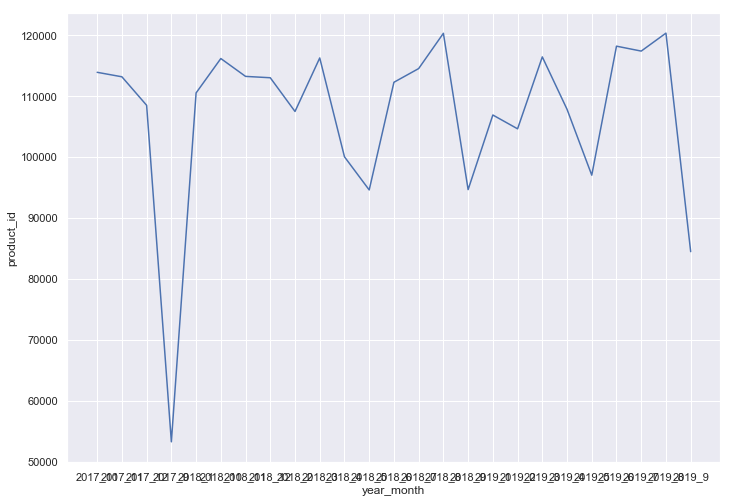

In [91]:
sns.lineplot(data = df_monthly_gby, x = 'year_month', y = 'product_id')

In [92]:
df_client = df1.copy()
df_client['date_order_2'] = df_client['date_order']

In [94]:
df_client = df_client.groupby(['client_id']).agg({'date_order' : 'min', 'date_order_2' : 'max', 'product_id' : 'count', 'sales_net' : 'sum'})

In [99]:
df_client['delta'] = df_client['date_order_2'] - df_client['date_order']
df_client['delta'] = df_client['delta'].apply(lambda x : x.days)

In [100]:
df_client.head()

,date_order,date_order_2,product_id,sales_net,delta
client_id,,,,,
6,2017-10-27,2019-08-13,40,5.882233e+03,655
7,2018-07-16,2018-12-24,15,1.190777e+03,161
14,2017-09-25,2019-09-20,12762,3.103187e+06,725
18,2017-09-26,2019-09-12,2224,2.194882e+05,716
25,2018-10-10,2018-10-10,4,3.745861e+02,0


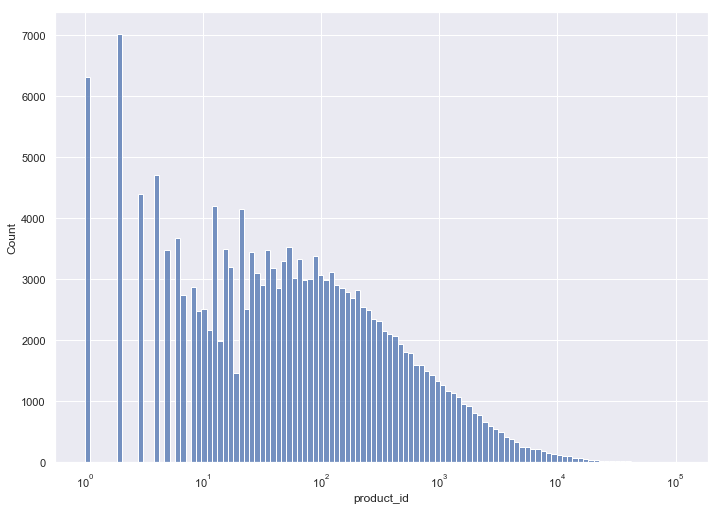

In [106]:
sns.histplot(data=df_client, x="product_id", log_scale = True)

In [ ]:
#Churn viz

In [111]:
df_client['first_month'] = df_client['date_order'].apply(lambda x : str(x.month) + '_' + str(x.year))
df_client['last_month'] = df_client['date_order_2'].apply(lambda x : str(x.month) + '_' + str(x.year))

In [124]:
df_client_filtered = df_client[df_client['date_order'] > datetime(2018, 4, 1)]
df_client_filtered = df_client_filtered[df_client_filtered['date_order_2'] < datetime(2019, 4, 30)]

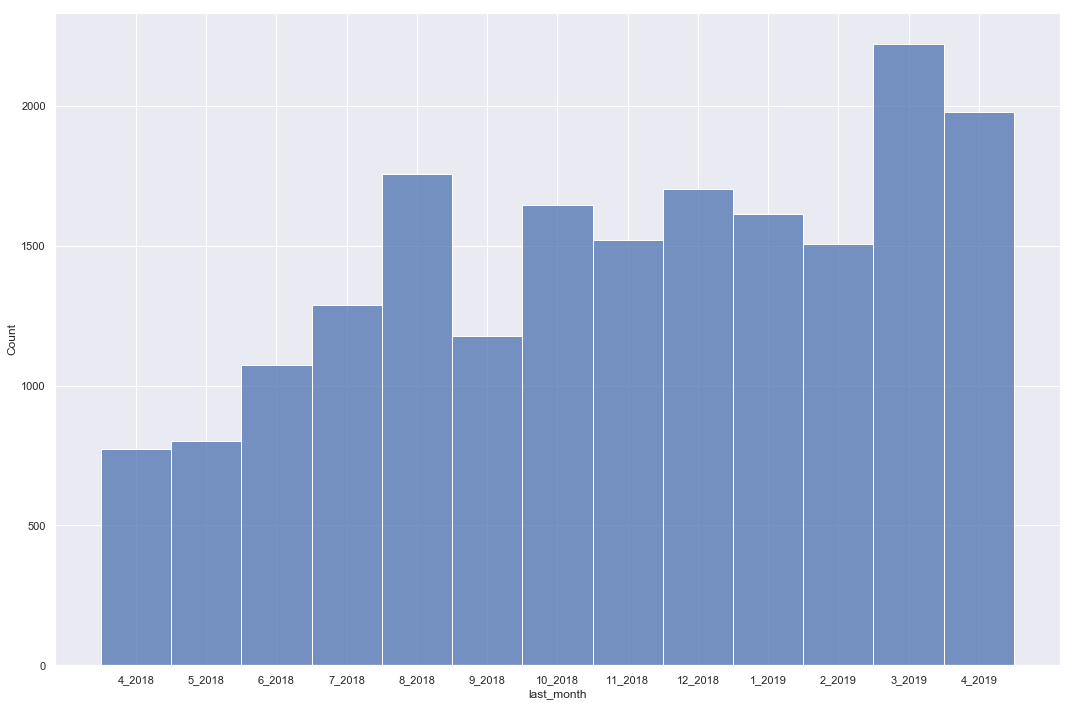

In [125]:
sns.histplot(data = df_client_filtered.sort_values(by = 'date_order_2'), x = 'last_month')

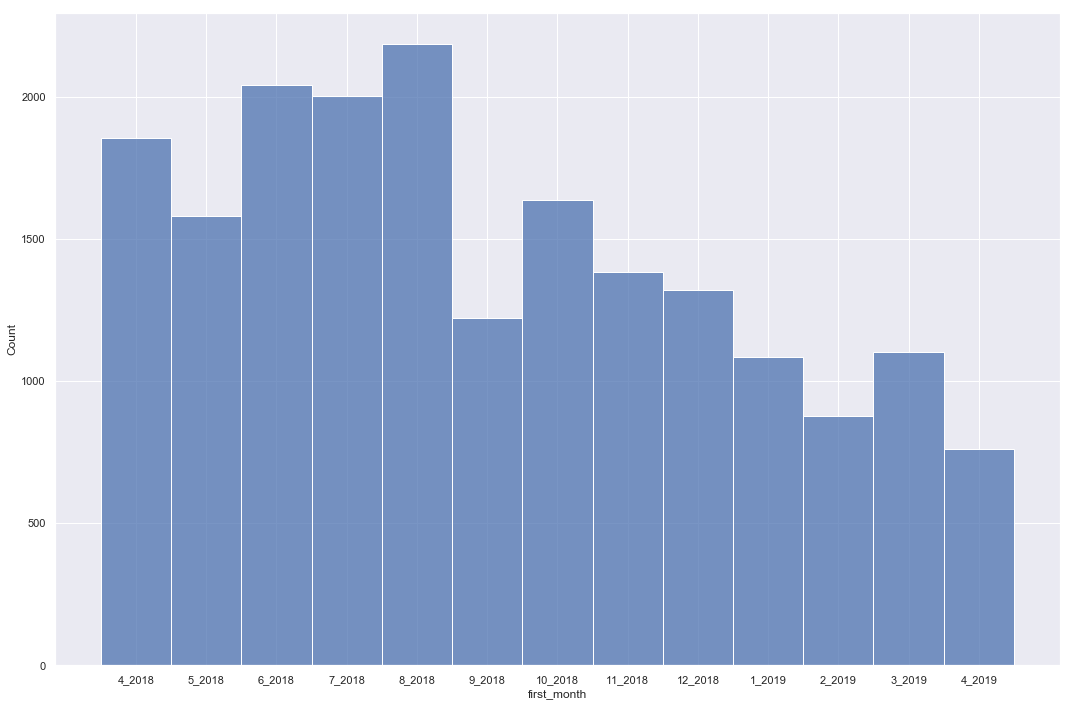

In [126]:
sns.histplot(data = df_client_filtered.sort_values(by = 'date_order'), x = 'first_month')

In [127]:
df_client_filtered.groupby(['first_month']).agg()

,date_order,date_order_2,product_id,sales_net,delta,first_month,last_month
client_id,,,,,,,
7,2018-07-16,2018-12-24,15,1190.777083,161,7_2018,12_2018
25,2018-10-10,2018-10-10,4,374.586096,0,10_2018,10_2018
55,2018-07-03,2018-10-11,9,4098.117484,100,7_2018,10_2018
60,2019-03-15,2019-03-19,7,0.000000,4,3_2019,3_2019
76,2018-10-23,2019-04-01,9,1068.572640,160,10_2018,4_2019


## Channel analysis by trimester

In [131]:
trimesters = {}
for k in range(1, 13):
    trimesters[k] = ((k-1)//3)+1

In [159]:
df_online = df1[df1['order_channel'] == 'online'].copy()
df_store = df1[df1['order_channel'] == 'at the store'].copy()
df_visit = df1[df1['order_channel'] == 'during the visit of a sales rep'].copy()
df_phone = df1[df1['order_channel'] == 'by phone'].copy()

In [160]:
df_online['trimester'] = df_online['date_order'].apply(lambda x : str(x.year) + '_' + str(trimesters[x.month]))

In [166]:
df_store['trimester'] = df_store['date_order'].apply(lambda x : str(x.year) + '_' + str(trimesters[x.month]))
df_visit['trimester'] = df_visit['date_order'].apply(lambda x : str(x.year) + '_' + str(trimesters[x.month]))
df_phone['trimester'] = df_phone['date_order'].apply(lambda x : str(x.year) + '_' + str(trimesters[x.month]))

In [161]:
df_online_trim = df_online.groupby(['trimester']).agg({'sales_net' : 'sum'}).reset_index()

In [167]:
df_store_trim = df_store.groupby(['trimester']).agg({'sales_net' : 'sum'}).reset_index()
df_visit_trim = df_visit.groupby(['trimester']).agg({'sales_net' : 'sum'}).reset_index()
df_phone_trim = df_phone.groupby(['trimester']).agg({'sales_net' : 'sum'}).reset_index()

In [168]:
df_online_trim['canal'] = 'online'
df_store_trim['canal'] = 'store'
df_visit_trim['canal'] = 'visit'
df_phone_trim['canal'] = 'phone'

In [182]:
df_all_trim = df_online_trim.append(df_store_trim).append(df_visit_trim).append(df_phone_trim)
df_all_trim = df_all_trim[df_all_trim['trimester'] != '2017_3']

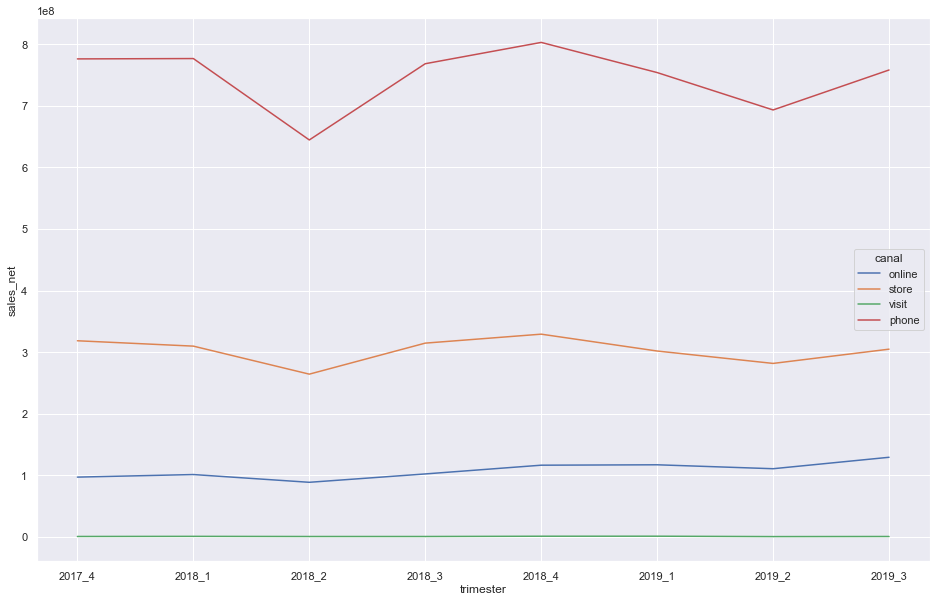

In [183]:
sns.lineplot(data = df_all_trim, x = 'trimester', y = 'sales_net', hue = 'canal')

### Price analysis

In [236]:
df1.head()

,date_order,date_invoice,product_id,client_id,sales_net,quantity,order_channel,branch_id
0,2017-09-25,2017-09-25,2376333,188502,155.44320,3,online,2732
1,2017-09-25,2017-09-25,2520527,835089,16.39440,3,at the store,10279
2,2017-09-25,2017-09-25,2536756,1977896,365.76624,21,online,6184
3,2017-09-25,2017-09-25,3028673,598816,8.59878,201,at the store,4200
4,2017-09-25,2017-09-25,203377,2086861,1093.37400,3,by phone,7051


In [277]:
df_product1 = df2[df2['product_id'] == 2376333].copy()

In [278]:
df_product1['price'] = df_product1['sales_net'] / df_product1['quantity']

In [279]:
df_product1 = df_product1[df_product1['date_order'].apply(lambda x : x.year) < 2018]

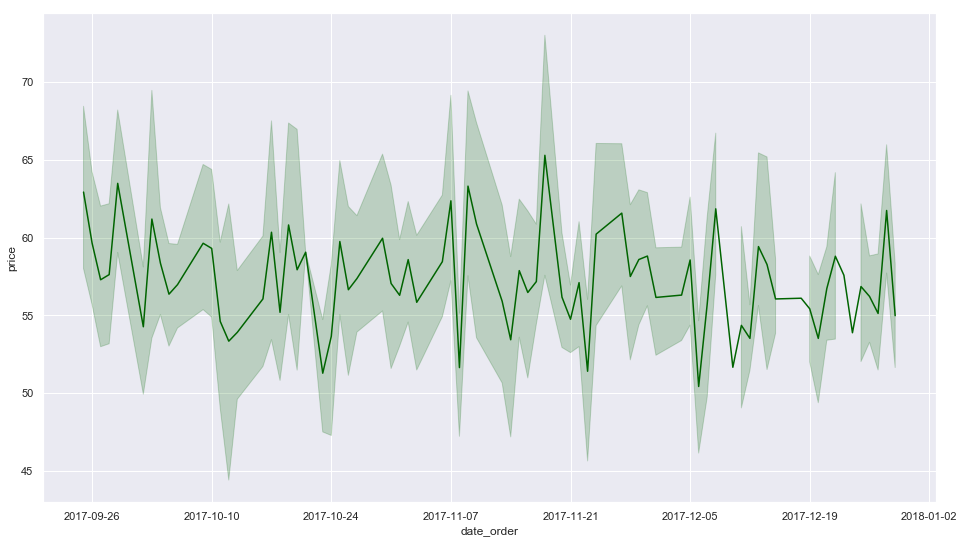

In [287]:
sns.lineplot(data = df_product1[(df_product1.price > 10)], x = 'date_order', y = 'price', color = 'darkgreen')

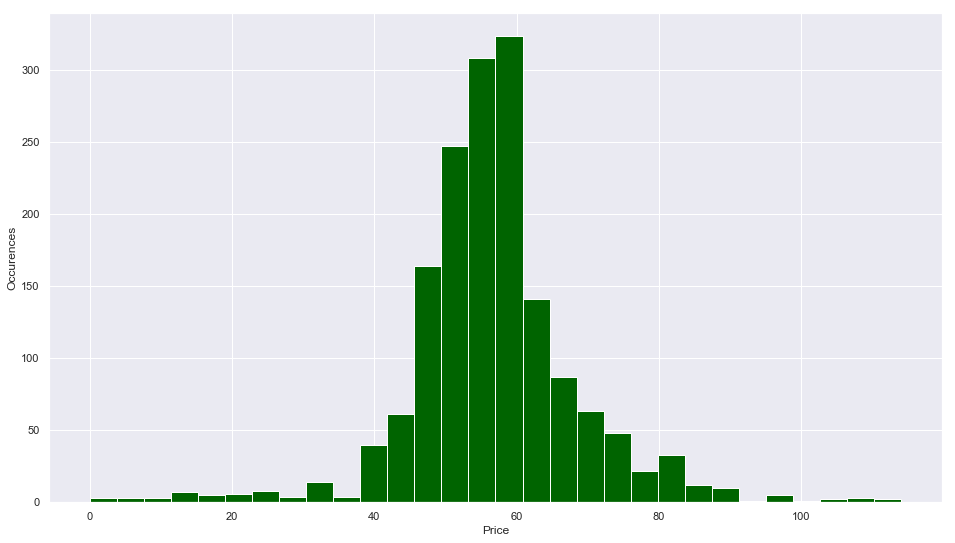

In [286]:
plt.hist(df_product1['price'], bins = 30, color = 'darkgreen')
plt.xlabel('Price')
plt.ylabel('Occurences')
plt.show()

In [264]:
df_product1[df_product1['price'] < 27]

,date_order,date_invoice,product_id,client_id,sales_net,quantity,order_channel,branch_id,price
7440641,2017-12-14,2017-12-19,203377,584154,0.0276,3,by phone,278,0.0092
28233284,2018-08-16,2018-08-16,203377,905866,0.0552,3,by phone,228,0.0184
34949493,2018-11-02,2018-11-02,203377,751381,0.2760,3,by phone,9215,0.0920


## Client segmentation

In [227]:
df_client = df1.copy()
df_client['date_order_max'] = df_client['date_order']
df_client['nb_channels'] = df_client['order_channel']
df_client = df_client.groupby(['client_id']).agg({'date_order' : 'min', 'date_order_max' : 'max', 'date_invoice' : 'count', 'product_id' : 'nunique', 'sales_net' : 'sum', 'nb_channels' : 'nunique', 'order_channel' :  lambda x: stats.mode(x), 'branch_id' : 'nunique'})

In [228]:
df_client.rename(columns = {'date_order' : 'date_order_min',
                           'date_invoice' : 'nb_orders',
                           'product_id' : 'nb_products',
                           'order_channel' : 'most_common_channel',
                           'branch_id' : 'nb_branches'}, inplace = True)

In [229]:
df_client['delta'] = df_client['date_order_max'] - df_client['date_order_min']
df_client['delta'] = df_client['delta'].apply(lambda x : x.days)
df_client['freq'] = df_client['nb_orders'] / (df_client['delta']+1)
df_client['avg_sales'] = df_client['sales_net'] / df_client['nb_orders']

In [233]:
df_client.head()

,date_order_min,date_order_max,nb_orders,nb_products,sales_net,nb_channels,most_common_channel,nb_branches,delta,freq,avg_sales
client_id,,,,,,,,,,,
6,2017-10-27,2019-08-13,40,37,5.882233e+03,2,by phone,1,655,0.060976,147.055825
7,2018-07-16,2018-12-24,15,10,1.190777e+03,1,at the store,1,161,0.092593,79.385139
14,2017-09-25,2019-09-20,12762,4898,3.103187e+06,3,by phone,9,725,17.578512,243.158351
18,2017-09-26,2019-09-12,2224,786,2.194882e+05,3,at the store,2,716,3.101813,98.690724
25,2018-10-10,2018-10-10,4,4,3.745861e+02,1,at the store,1,0,4.000000,93.646524


In [234]:
df_client.describe()

,nb_orders,nb_products,sales_net,nb_channels,nb_branches,delta,freq,avg_sales
count,170589.000000,170589.000000,1.705890e+05,170589.000000,170589.000000,170589.000000,170589.000000,170589.000000
mean,371.180522,155.689716,5.491304e+04,1.839656,2.508040,428.901576,1.199386,213.829923
std,1430.183785,396.214366,2.438333e+05,0.716017,4.708905,273.705494,3.682848,1338.526500
min,1.000000,1.000000,-9.239541e+02,1.000000,1.000000,0.000000,0.002793,-90.160000
25%,12.000000,9.000000,1.271890e+03,1.000000,1.000000,154.000000,0.080838,68.356544
50%,50.000000,35.000000,6.163601e+03,2.000000,1.000000,523.000000,0.258065,110.459957
75%,214.000000,134.000000,2.933579e+04,2.000000,3.000000,690.000000,1.000000,189.835619
max,105636.000000,30812.000000,2.755879e+07,5.000000,537.000000,729.000000,396.000000,248660.940568


In [34]:
#df_client.to_csv('dataset_clients.csv')

In [200]:
df_client_clean = df_client[df_client['freq'] < 100]
df_client_clean = df_client_clean[df_client_clean['nb_branches'] < 100]

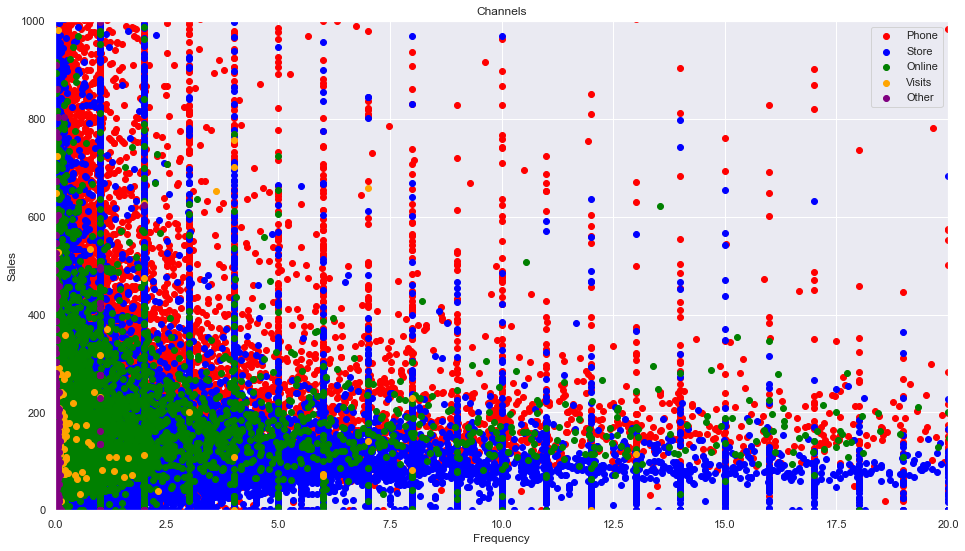

In [193]:
#filter rows of original data
filtered_label0 = df_client_clean[df_client_clean['most_common_channel'] == 'by phone']
filtered_label1 = df_client_clean[df_client_clean['most_common_channel'] == 'at the store']
filtered_label2 = df_client_clean[df_client_clean['most_common_channel'] == 'online']
filtered_label3 = df_client_clean[df_client_clean['most_common_channel'] == 'during the visit of a sales rep']
filtered_label4 = df_client_clean[df_client_clean['most_common_channel'] == 'other']
 
#Plotting the results
plt.scatter(filtered_label0['freq'] , filtered_label0['avg_sales'] , color = 'red', label = 'Phone')
plt.scatter(filtered_label1['freq'] , filtered_label1['avg_sales'] , color = 'blue', label = 'Store')
plt.scatter(filtered_label2['freq'] , filtered_label2['avg_sales'] , color = 'green', label = 'Online')
plt.scatter(filtered_label3['freq'] , filtered_label3['avg_sales'] , color = 'orange', label = 'Visits')
plt.scatter(filtered_label4['freq'] , filtered_label4['avg_sales'] , color = 'purple', label = 'Other')
plt.title('Channels')
plt.xlabel('Frequency')
plt.ylabel('Sales')
plt.legend()
plt.xlim([0,20])
plt.ylim([0,1000])
plt.show()

In [205]:
X = df_client_clean[['freq', 'sales_net']].to_numpy()
X = StandardScaler().fit_transform(X)

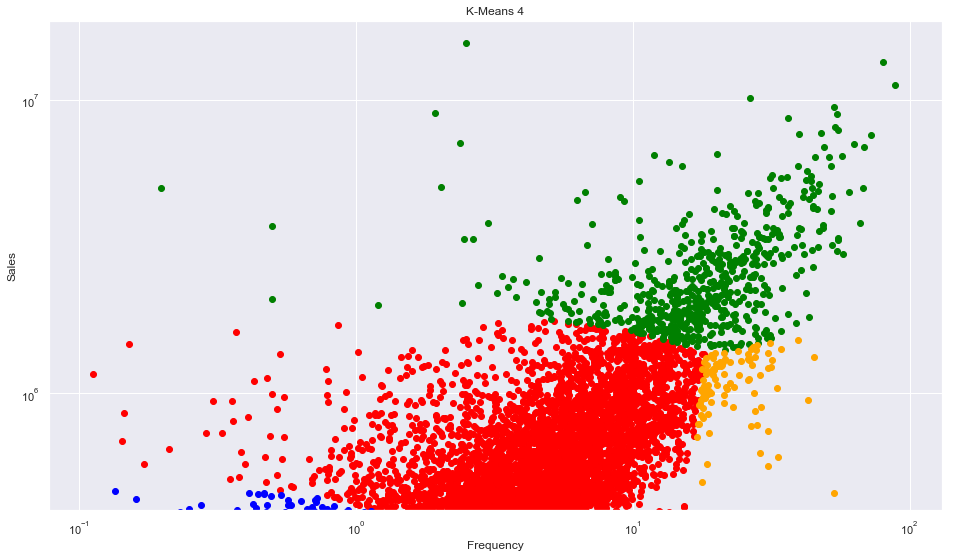

In [206]:
kmeans = KMeans(n_clusters=4, random_state=1).fit(X)
df_client_clean['label'] = kmeans.labels_

#filter rows of original data
filtered_label0 = df_client_clean[df_client_clean['label'] == 0]
filtered_label1 = df_client_clean[df_client_clean['label'] == 1]
filtered_label2 = df_client_clean[df_client_clean['label'] == 2]
filtered_label3 = df_client_clean[df_client_clean['label'] == 3]
 
#Plotting the results
plt.scatter(filtered_label0['freq'] , filtered_label0['sales_net'] , color = 'red')
plt.scatter(filtered_label1['freq'] , filtered_label1['sales_net'] , color = 'blue')
plt.scatter(filtered_label2['freq'] , filtered_label2['sales_net'] , color = 'green')
plt.scatter(filtered_label3['freq'] , filtered_label3['sales_net'] , color = 'orange')
plt.title('K-Means 4')
plt.xlabel('Frequency')
plt.ylabel('Sales')
plt.xscale('log')
plt.yscale('log')
plt.show()

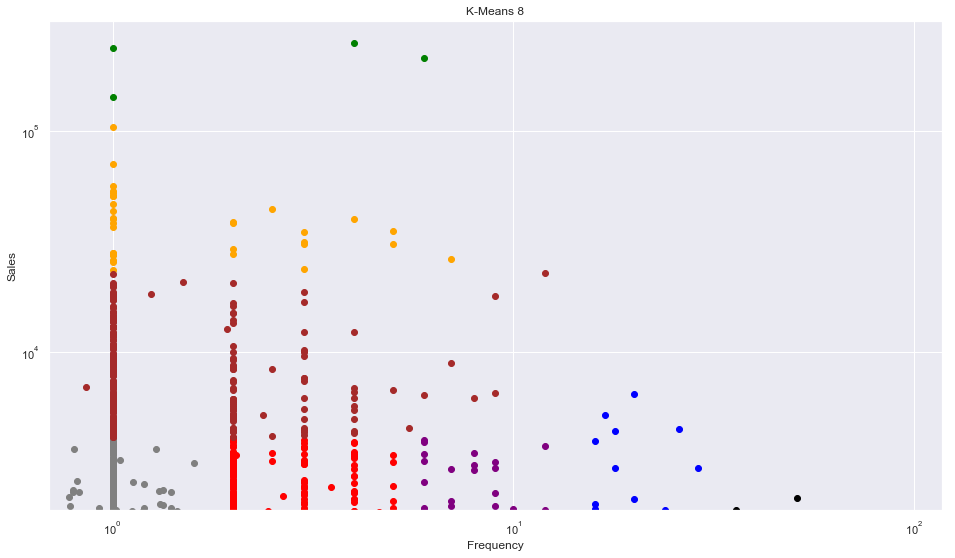

In [204]:
kmeans = KMeans(n_clusters=8, random_state=1).fit(X)
df_client_clean['label'] = kmeans.labels_

#filter rows of original data
filtered_label0 = df_client_clean[df_client_clean['label'] == 0]
filtered_label1 = df_client_clean[df_client_clean['label'] == 1]
filtered_label2 = df_client_clean[df_client_clean['label'] == 2]
filtered_label3 = df_client_clean[df_client_clean['label'] == 3]
filtered_label4 = df_client_clean[df_client_clean['label'] == 4]
filtered_label5 = df_client_clean[df_client_clean['label'] == 5]
filtered_label6 = df_client_clean[df_client_clean['label'] == 6]
filtered_label7 = df_client_clean[df_client_clean['label'] == 7]
 
#Plotting the results
plt.scatter(filtered_label0['freq'] , filtered_label0['avg_sales'] , color = 'grey')
plt.scatter(filtered_label1['freq'] , filtered_label1['avg_sales'] , color = 'blue')
plt.scatter(filtered_label2['freq'] , filtered_label2['avg_sales'] , color = 'green')
plt.scatter(filtered_label3['freq'] , filtered_label3['avg_sales'] , color = 'orange')
plt.scatter(filtered_label4['freq'] , filtered_label4['avg_sales'] , color = 'purple')
plt.scatter(filtered_label5['freq'] , filtered_label5['avg_sales'] , color = 'red')
plt.scatter(filtered_label6['freq'] , filtered_label6['avg_sales'] , color = 'brown')
plt.scatter(filtered_label7['freq'] , filtered_label7['avg_sales'] , color = 'black')
plt.title('K-Means 8')
plt.xlabel('Frequency')
plt.ylabel('Sales')
plt.xscale('log')
plt.yscale('log')
plt.show()

In [169]:
df_client_clean.describe()

,nb_orders,nb_products,sales_net,nb_channels,nb_branches,delta,freq,avg_sales,label
count,170536.000000,170536.000000,1.705360e+05,170536.000000,170536.000000,170536.000000,170536.000000,170536.000000,170536.000000
mean,367.748305,154.985469,5.425565e+04,1.839524,2.471390,428.887596,1.176880,213.829260,0.024306
std,1365.982334,385.831784,2.224587e+05,0.715850,3.551403,273.681132,3.071434,1338.692645,0.164954
min,1.000000,1.000000,-9.239541e+02,1.000000,1.000000,0.000000,0.002793,-90.160000,0.000000
25%,12.000000,9.000000,1.271696e+03,1.000000,1.000000,154.000000,0.080808,68.355188,0.000000
50%,50.000000,35.000000,6.159312e+03,2.000000,1.000000,523.000000,0.257943,110.459296,0.000000
75%,214.000000,133.000000,2.929985e+04,2.000000,3.000000,690.000000,1.000000,189.836794,0.000000
max,64192.000000,11379.000000,1.557873e+07,5.000000,96.000000,729.000000,93.000000,248660.940568,3.000000


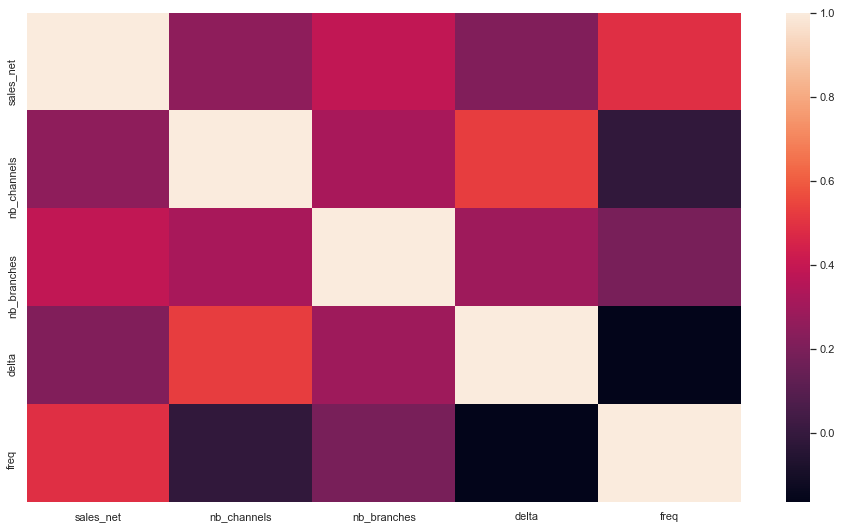

In [128]:
sns.heatmap(data = df_client_clean[['sales_net', 'nb_channels', 'nb_branches', 'delta', 'freq']].corr())

In [136]:
df1[df1.client_id == 1190146]

,date_order,date_invoice,product_id,client_id,sales_net,quantity,order_channel,branch_id
53748308,2019-06-18,2019-06-18,1810405,1190146,0.0000,3,at the store,8768
53748309,2019-06-18,2019-06-18,2171681,1190146,0.0000,13,at the store,8768
53760904,2019-06-18,2019-06-18,1445532,1190146,0.0000,7,at the store,8768
53772641,2019-06-18,2019-06-18,2666576,1190146,18.5472,21,at the store,8768
53786477,2019-06-18,2019-06-18,1273192,1190146,0.0000,3,at the store,8768
...,...,...,...,...,...,...,...,...
55621194,2019-06-18,2019-07-03,2382229,1190146,-9.1770,5,at the store,8768
55703081,2019-06-18,2019-07-03,1407448,1190146,-902.9800,13,at the store,8768
55703144,2019-06-18,2019-07-03,2573700,1190146,-27.4275,9,at the store,8768
55703145,2019-06-18,2019-07-03,1544845,1190146,-165.2550,5,at the store,8768


In [135]:
df_client[df_client.index == 1190146]

,date_order_min,date_order_max,nb_orders,nb_products,sales_net,nb_channels,most_common_channel,nb_branches,delta,freq
client_id,,,,,,,,,,
1190146,2019-06-18,2019-06-18,396,114,-63.146375,2,at the store,1,0,396.0


In [138]:
df_client.sort_values(by = 'freq').tail(10)

,date_order_min,date_order_max,nb_orders,nb_products,sales_net,nb_channels,most_common_channel,nb_branches,delta,freq
client_id,,,,,,,,,,
1001170,2019-09-17,2019-09-17,144,72,1.681461e+02,1,by phone,1,0,144.000000
417576,2017-09-25,2019-09-20,105636,30812,2.755879e+07,3,by phone,537,725,145.504132
12941,2019-09-13,2019-09-18,886,194,5.662624e+04,1,by phone,1,5,147.666667
316150,2019-02-28,2019-02-28,154,67,-1.028795e+02,1,by phone,1,0,154.000000
878680,2018-10-03,2018-10-03,168,60,-6.881301e+01,1,at the store,1,0,168.000000
1125467,2019-02-18,2019-02-20,557,7,1.080468e+04,1,by phone,1,2,185.666667
1320609,2018-03-12,2018-03-12,226,40,5.255929e+04,1,by phone,1,0,226.000000
1205772,2018-09-14,2018-09-14,231,71,1.614353e-11,1,at the store,1,0,231.000000
1284538,2019-09-13,2019-09-13,378,74,-2.147804e+00,1,by phone,1,0,378.000000


In [235]:
#Différence clients
df_client.describe()

,nb_orders,nb_products,sales_net,nb_channels,nb_branches,delta,freq,avg_sales
count,170589.000000,170589.000000,1.705890e+05,170589.000000,170589.000000,170589.000000,170589.000000,170589.000000
mean,371.180522,155.689716,5.491304e+04,1.839656,2.508040,428.901576,1.199386,213.829923
std,1430.183785,396.214366,2.438333e+05,0.716017,4.708905,273.705494,3.682848,1338.526500
min,1.000000,1.000000,-9.239541e+02,1.000000,1.000000,0.000000,0.002793,-90.160000
25%,12.000000,9.000000,1.271890e+03,1.000000,1.000000,154.000000,0.080838,68.356544
50%,50.000000,35.000000,6.163601e+03,2.000000,1.000000,523.000000,0.258065,110.459957
75%,214.000000,134.000000,2.933579e+04,2.000000,3.000000,690.000000,1.000000,189.835619
max,105636.000000,30812.000000,2.755879e+07,5.000000,537.000000,729.000000,396.000000,248660.940568


In [232]:
#Pricing/Promos

In [288]:
#Variation de la demande 

In [311]:
df_product = df2.groupby(['product_id']).agg({'sales_net' : 'sum'}).reset_index()

In [312]:
total_sales = df_product.sales_net.sum()

In [314]:
df_product = df_product.sort_values(by = 'sales_net', ascending = False).reset_index().reset_index()

In [325]:
df_product.head()

,level_0,index,product_id,sales_net
0,0,501253,2681878,4.072189e+07
1,1,86334,463156,2.539948e+07
2,2,475111,2542409,2.415942e+07
3,3,233910,1253061,2.389214e+07
4,4,247463,1325810,2.010442e+07


In [324]:
for k in range(1,21) :
    n = int(len(df_product)*(k/20))
    prop = df_product.head(n).sales_net.sum() / total_sales
    print(5 * k, "% des produits sont à l'origine de", round(100 * prop, 1), "% du chiffre d'affaire")

5 % des produits sont à l'origine de 83.2 % du chiffre d'affaire
10 % des produits sont à l'origine de 90.4 % du chiffre d'affaire
15 % des produits sont à l'origine de 93.6 % du chiffre d'affaire
20 % des produits sont à l'origine de 95.4 % du chiffre d'affaire
25 % des produits sont à l'origine de 96.6 % du chiffre d'affaire
30 % des produits sont à l'origine de 97.4 % du chiffre d'affaire
35 % des produits sont à l'origine de 98.0 % du chiffre d'affaire
40 % des produits sont à l'origine de 98.5 % du chiffre d'affaire
45 % des produits sont à l'origine de 98.9 % du chiffre d'affaire
50 % des produits sont à l'origine de 99.1 % du chiffre d'affaire
55 % des produits sont à l'origine de 99.3 % du chiffre d'affaire
60 % des produits sont à l'origine de 99.5 % du chiffre d'affaire
65 % des produits sont à l'origine de 99.7 % du chiffre d'affaire
70 % des produits sont à l'origine de 99.8 % du chiffre d'affaire
75 % des produits sont à l'origine de 99.8 % du chiffre d'affaire
80 % des pr

In [326]:
#Churn viz

In [328]:
df_client.head()

,date_order_min,date_order_max,nb_orders,nb_products,sales_net,nb_channels,most_common_channel,nb_branches,delta,freq,avg_sales
client_id,,,,,,,,,,,
6,2017-10-27,2019-08-13,40,37,5.882233e+03,2,by phone,1,655,0.060976,147.055825
7,2018-07-16,2018-12-24,15,10,1.190777e+03,1,at the store,1,161,0.092593,79.385139
14,2017-09-25,2019-09-20,12762,4898,3.103187e+06,3,by phone,9,725,17.578512,243.158351
18,2017-09-26,2019-09-12,2224,786,2.194882e+05,3,at the store,2,716,3.101813,98.690724
25,2018-10-10,2018-10-10,4,4,3.745861e+02,1,at the store,1,0,4.000000,93.646524


In [330]:
df_churn = df_client.reset_index().groupby(['date_order_max']).agg({'client_id' : 'count'}).reset_index()

In [335]:
df_churn['month_year'] = df_churn.date_order_max.apply(lambda x : datetime(x.year, x.month, 1))

In [339]:
df_churn_month = df_churn.groupby('month_year').agg({'client_id' : 'sum'}).reset_index()

In [346]:
df_churn_stable = df_churn_month[df_churn_month.month_year < datetime(2019, 2, 1)]
df_churn_stable = df_churn_stable[df_churn_stable.month_year > datetime(2017, 9, 1)]

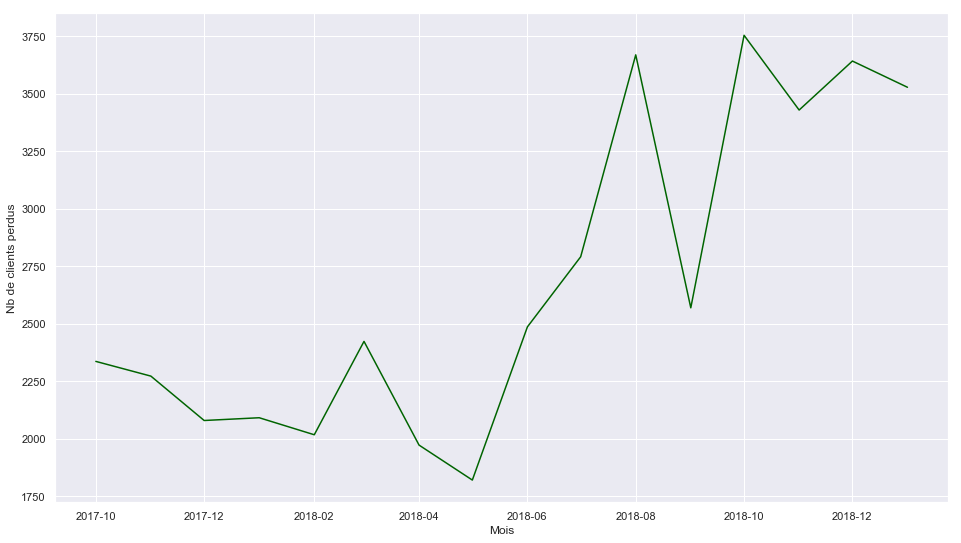

In [383]:
plt.plot(df_churn_stable.month_year, df_churn_stable.client_id, color = 'darkgreen')
plt.xlabel('Mois')
plt.ylabel('Nb de clients perdus')
plt.show()

In [377]:
df_client_stable = df_client[df_client.date_order_min < datetime(2019,3,22)]
df_client_stable = df_client_stable[df_client_stable.date_order_max > datetime(2018,3,22)]

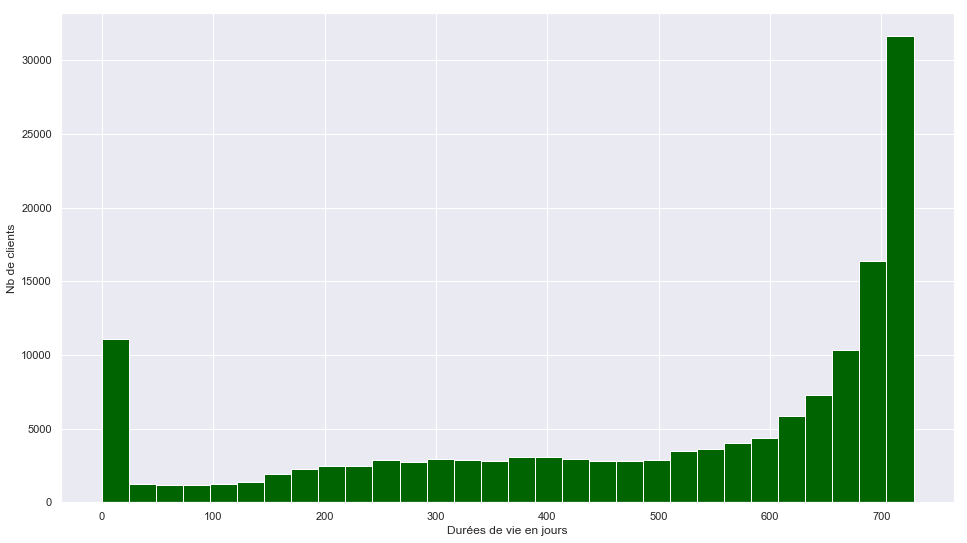

In [385]:
plt.hist(df_client_stable.delta, bins = 30, color = 'darkgreen')
plt.xlabel('Durées de vie en jours')
plt.ylabel('Nb de clients')
plt.show()

In [386]:
df_client_stable.delta.mean()

498.31111493817383

## Churn prediction

In [387]:
df_client.head()

,date_order_min,date_order_max,nb_orders,nb_products,sales_net,nb_channels,most_common_channel,nb_branches,delta,freq,avg_sales
client_id,,,,,,,,,,,
6,2017-10-27,2019-08-13,40,37,5.882233e+03,2,by phone,1,655,0.060976,147.055825
7,2018-07-16,2018-12-24,15,10,1.190777e+03,1,at the store,1,161,0.092593,79.385139
14,2017-09-25,2019-09-20,12762,4898,3.103187e+06,3,by phone,9,725,17.578512,243.158351
18,2017-09-26,2019-09-12,2224,786,2.194882e+05,3,at the store,2,716,3.101813,98.690724
25,2018-10-10,2018-10-10,4,4,3.745861e+02,1,at the store,1,0,4.000000,93.646524


In [388]:
df2.head()

,date_order,date_invoice,product_id,client_id,sales_net,quantity,order_channel,branch_id
0,2017-09-25,2017-09-25,2376333,188502,155.44320,3,online,2732
1,2017-09-25,2017-09-25,2520527,835089,16.39440,3,at the store,10279
2,2017-09-25,2017-09-25,2536756,1977896,365.76624,21,online,6184
3,2017-09-25,2017-09-25,3028673,598816,8.59878,201,at the store,4200
4,2017-09-25,2017-09-25,203377,2086861,1093.37400,3,by phone,7051


In [389]:
date0 = datetime(2018,6,1)

In [539]:
df_before_1 = df2[df2.date_order < date0]
df_before_1 = df_before_1[df_before_1.date_order >= (date0 - timedelta(30))]

df_before_6 = df2[df2.date_order < date0]
df_before_6 = df_before_6[df_before_6.date_order >= (date0 - timedelta(180))]

df_after = df2[df2.date_order >= date0]
df_after = df_after[df_after.date_order < (date0 + timedelta(90))]

In [485]:
df_clients_test = df_before_6.copy().head(100000)
df_clients_test = df_clients_test.groupby(['client_id']).agg({'date_invoice' : 'count', 'product_id' : 'nunique', 'branch_id' : 'nunique'}).reset_index()
df_clients_test.rename(columns = {'date_invoice' : 'nb_orders',
                           'product_id' : 'nb_products',
                           'branch_id' : 'nb_branches'}, inplace = True)

In [542]:
def rfm(df_orders, date, client_id):
    df_client = df_orders[df_orders.client_id == client_id]
    df_client_1 = df_client[df_client.date_order > (date - timedelta(30))]
    last_order = df_client.date_order.max()
    first_order = df_client.date_order.min()
    delta = (date - first_order).days
    r = (date-last_order).days
    f6 = df_client.date_order.nunique() / (delta + 1)
    m6 = df_client.sales_net.sum()
    delta_1 = max(delta, 29)
    f1 = df_client_1.date_order.nunique() / (delta_1 + 1)
    m1 = df_client_1.sales_net.sum()
    f_ratio = 0
    if f6 != 0:
        f_ratio = f1/f6
    m_ratio = 0
    if m6 != 0:
        m_ratio = 6*m1/m6
    return (r,f6,f1, m6, m1, f_ratio, m_ratio)


def channels(df_orders, client) :
    df_client = df_orders[df_orders.client_id == client]
    channels = df_client.order_channel.unique()
    (online, store, phone, visit, other) = (0, 0, 0, 0, 0)
    if 'online' in channels :
        online = 1
    if 'at the store' in channels :
        store = 1
    if 'by phone' in channels :
        phone = 1
    if 'during the visit of a sales rep' in channels :
        visit = 1
    if 'other' in channels :
        other = 1
    return (online, store, phone, visit, other)


def is_churn(df_before, df_after, client_id, time_ratio):
    client_before = df_before[df_before.client_id == client_id]
    client_after = df_after[df_after.client_id == client_id]
    if len(client_before) > 10*time_ratio*len(client_after) :
        return 1
    return 0
    

In [487]:
df_clients_test.head()

,client_id,nb_orders,nb_products,nb_branches
0,14,31,30,1
1,252,4,4,1
2,259,2,2,2
3,811,2,2,1
4,1101,13,13,1


In [490]:
df_clients_test = df_clients_test.head(1000).copy()

In [492]:
df_clients_test['R'] = 0
df_clients_test['F6'] = 0
df_clients_test['F1'] = 0
df_clients_test['M6'] = 0
df_clients_test['M1'] = 0
df_clients_test['F_ratio'] = 0
df_clients_test['M_ratio'] = 0

for client in tqdm(df_clients_test.client_id.unique()):
    (r,f6,f1, m6, m1, f_r, m_r) = rfm(df_before_6, date0, client)
    df_clients_test.loc[df_clients_test.client_id == client, 'R'] = r
    df_clients_test.loc[df_clients_test.client_id == client, 'F6'] = f6
    df_clients_test.loc[df_clients_test.client_id == client, 'F1'] = f1
    df_clients_test.loc[df_clients_test.client_id == client, 'M6'] = m6
    df_clients_test.loc[df_clients_test.client_id == client, 'M1'] = m1
    df_clients_test.loc[df_clients_test.client_id == client, 'F_ratio'] = f_r
    df_clients_test.loc[df_clients_test.client_id == client, 'M_ratio'] = m_r

100%|██████████| 1000/1000 [00:13<00:00, 73.54it/s]


In [546]:
df_clients_test['mean_basket'] = df_clients_test['M6']/df_clients_test['nb_orders']

In [547]:
df_clients_test.head()

,client_id,nb_orders,nb_products,nb_branches,R,F6,F1,M6,M1,F_ratio,M_ratio,Online,Store,Phone,Visit,Other,churn,mean_basket
0,14,31,30,1,1,0.688889,0.111111,705795.126854,86909.322475,0.161290,0.738821,1,1,1,0,0,0,22767.584737
1,252,4,4,1,1,0.329609,0.033520,42944.428837,6823.473227,0.101695,0.953345,0,1,1,0,1,0,10736.107209
2,259,2,2,2,1,0.233333,0.022222,51331.110572,4980.355753,0.095238,0.582145,0,1,1,0,0,0,25665.555286
3,811,2,2,1,21,0.133333,0.016667,50246.216138,2318.164975,0.125000,0.276817,0,0,1,0,0,0,25123.108069
4,1101,13,13,1,15,0.402235,0.011173,80603.093692,1090.520528,0.027778,0.081177,0,1,1,0,1,1,6200.237976


In [494]:
df_clients_test['Online'] = 0
df_clients_test['Store'] = 0
df_clients_test['Phone'] = 0
df_clients_test['Visit'] = 0
df_clients_test['Other'] = 0

for client in tqdm(df_clients_test.client_id.unique()):
    (online, store, phone, visit, other) = channels(df_before_6, client)
    df_clients_test.loc[df_clients_test.client_id == client, 'Online'] = online
    df_clients_test.loc[df_clients_test.client_id == client, 'Store'] = store
    df_clients_test.loc[df_clients_test.client_id == client, 'Phone'] = phone
    df_clients_test.loc[df_clients_test.client_id == client, 'Visit'] = visit
    df_clients_test.loc[df_clients_test.client_id == client, 'Other'] = other

100%|██████████| 1000/1000 [00:11<00:00, 84.69it/s]


In [515]:
df_clients_test.head()

,client_id,nb_orders,nb_products,nb_branches,R,F6,F1,M6,M1,F_ratio,M_ratio,Online,Store,Phone,Visit,Other,churn
0,14,31,30,1,1,0.688889,0.111111,705795.126854,86909.322475,0.161290,0.738821,1,1,1,0,0,0
1,252,4,4,1,1,0.329609,0.033520,42944.428837,6823.473227,0.101695,0.953345,0,1,1,0,1,0
2,259,2,2,2,1,0.233333,0.022222,51331.110572,4980.355753,0.095238,0.582145,0,1,1,0,0,0
3,811,2,2,1,21,0.133333,0.016667,50246.216138,2318.164975,0.125000,0.276817,0,0,1,0,0,0
4,1101,13,13,1,15,0.402235,0.011173,80603.093692,1090.520528,0.027778,0.081177,0,1,1,0,1,1


In [543]:
df_clients_test['churn'] = 0
for client in tqdm(df_clients_test.client_id.unique()):
    df_clients_test.loc[df_clients_test.client_id == client, 'churn'] = is_churn(df_before_6, df_after, client, 2)

100%|██████████| 1000/1000 [00:17<00:00, 57.48it/s]


In [537]:
df_clients_test.sample(10)

,client_id,nb_orders,nb_products,nb_branches,R,F6,F1,M6,M1,F_ratio,M_ratio,Online,Store,Phone,Visit,Other,churn
212,25270,1,1,1,1,0.261111,0.050000,39177.142140,15549.635576,0.191489,2.381435,0,1,1,0,0,0
344,38720,1,1,1,179,0.005556,0.000000,88.734000,0.000000,0.000000,0.000000,0,0,1,0,0,1
16,2776,3,3,1,1,0.273743,0.027933,25070.236902,3290.236388,0.102041,0.787444,0,1,1,0,0,0
130,16480,7,7,1,3,0.083333,0.005556,7499.114608,287.716200,0.066667,0.230200,0,1,1,0,0,0
882,104805,2,2,1,8,0.122222,0.011111,45509.564263,944.712887,0.090909,0.124551,0,1,1,0,0,1
242,28316,1,1,1,42,0.038889,0.000000,2960.543225,0.000000,0.000000,0.000000,0,1,1,0,0,0
610,68719,12,12,1,23,0.305556,0.005556,44730.709262,5.278500,0.018182,0.000708,0,1,1,0,0,0
40,5741,1,1,1,38,0.167598,0.000000,12311.933260,0.000000,0.000000,0.000000,0,1,1,0,0,0
316,36083,2,2,1,1,0.391061,0.078212,41595.930731,6659.634503,0.200000,0.960618,0,1,1,0,1,0
602,68305,1,1,1,11,0.039106,0.005587,592.530048,71.473267,0.142857,0.723743,0,1,0,0,0,0


In [544]:
df_clients_test.churn.value_counts()

0    915
1     85
Name: churn, dtype: int64

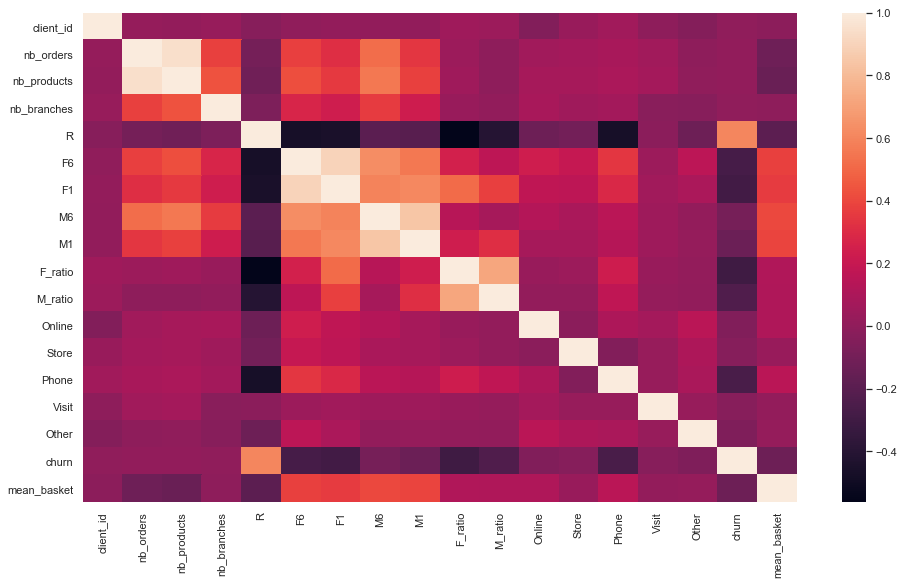

In [548]:
sns.heatmap(df_clients_test.corr())

### Preprocessing

In [550]:
def rfm(df_orders, date, client_id):
    df_client = df_orders[df_orders.client_id == client_id]
    df_client_1 = df_client[df_client.date_order > (date - timedelta(30))]
    last_order = df_client.date_order.max()
    first_order = df_client.date_order.min()
    delta = (date - first_order).days
    r = (date-last_order).days
    f6 = df_client.date_order.nunique() / (delta + 1)
    m6 = df_client.sales_net.sum()
    delta_1 = max(delta, 29)
    f1 = df_client_1.date_order.nunique() / (delta_1 + 1)
    m1 = df_client_1.sales_net.sum()
    f_ratio = 0
    if f6 != 0:
        f_ratio = f1/f6
    m_ratio = 0
    if m6 != 0:
        m_ratio = 6*m1/m6
    return (r,f6,f1, m6, m1, f_ratio, m_ratio)


def channels(df_orders, client) :
    df_client = df_orders[df_orders.client_id == client]
    channels = df_client.order_channel.unique()
    (online, store, phone, visit, other) = (0, 0, 0, 0, 0)
    if 'online' in channels :
        online = 1
    if 'at the store' in channels :
        store = 1
    if 'by phone' in channels :
        phone = 1
    if 'during the visit of a sales rep' in channels :
        visit = 1
    if 'other' in channels :
        other = 1
    return (online, store, phone, visit, other)


def is_churn(df_before, df_after, client_id, time_ratio):
    client_before = df_before[df_before.client_id == client_id]
    client_after = df_after[df_after.client_id == client_id]
    if len(client_before) > 10*time_ratio*len(client_after) :
        return 1
    return 0

In [636]:
#Les dates sont choisies arbitrairement
dates = [datetime(2018, 6,1), datetime(2018, 8,6), datetime(2018, 10,11), datetime(2018, 12,16), datetime(2019, 2,21), datetime(2019, 4,26)]

#Number of clients chosen per date
n_per_date = 20000 

In [637]:
df_train = pd.DataFrame()
for date in dates :
    t0 = time()
    print("Date :", date)
    print("Computing dataframes")
    df_before_1 = df2[df2.date_order < date]
    df_before_1 = df_before_1[df_before_1.date_order >= (date - timedelta(30))]

    df_before_6 = df2[df2.date_order < date]
    df_before_6 = df_before_6[df_before_6.date_order >= (date - timedelta(180))]

    df_after = df2[df2.date_order >= date]
    df_after = df_after[df_after.date_order < (date + timedelta(90))]
    
    df_train_date = df_before_6.copy()
    clients_to_keep = choice(a = df_train_date.client_id.unique(), size = min(n_per_date, df_train_date.client_id.nunique()), replace=False)
    df_train_date = df_train_date[df_train_date.client_id.isin(clients_to_keep)]
    df_train_date = df_train_date.groupby(['client_id']).agg({'date_invoice' : 'count', 'product_id' : 'nunique', 'branch_id' : 'nunique'}).reset_index()
    df_train_date.rename(columns = {'date_invoice' : 'nb_orders',
                               'product_id' : 'nb_products',
                               'branch_id' : 'nb_branches'}, inplace = True)
    
    print("Computing features")

    df_train_date['R'] = 0
    df_train_date['F6'] = 0
    df_train_date['F1'] = 0
    df_train_date['M6'] = 0
    df_train_date['M1'] = 0
    df_train_date['F_ratio'] = 0
    df_train_date['M_ratio'] = 0

    for client in tqdm(df_train_date.client_id.unique()):
        (r,f6,f1, m6, m1, f_r, m_r) = rfm(df_before_6, date, client)
        df_train_date.loc[df_train_date.client_id == client, 'R'] = r
        df_train_date.loc[df_train_date.client_id == client, 'F6'] = f6
        df_train_date.loc[df_train_date.client_id == client, 'F1'] = f1
        df_train_date.loc[df_train_date.client_id == client, 'M6'] = m6
        df_train_date.loc[df_train_date.client_id == client, 'M1'] = m1
        df_train_date.loc[df_train_date.client_id == client, 'F_ratio'] = f_r
        df_train_date.loc[df_train_date.client_id == client, 'M_ratio'] = m_r
        
    df_train_date['mean_basket'] = df_train_date['M6']/df_train_date['nb_orders']

    df_train_date['Online'] = 0
    df_train_date['Store'] = 0
    df_train_date['Phone'] = 0
    df_train_date['Visit'] = 0
    df_train_date['Other'] = 0


    for client in tqdm(df_train_date.client_id.unique()):
        (online, store, phone, visit, other) = channels(df_before_6, client)
        df_train_date.loc[df_train_date.client_id == client, 'Online'] = online
        df_train_date.loc[df_train_date.client_id == client, 'Store'] = store
        df_train_date.loc[df_train_date.client_id == client, 'Phone'] = phone
        df_train_date.loc[df_train_date.client_id == client, 'Visit'] = visit
        df_train_date.loc[df_train_date.client_id == client, 'Other'] = other
        
    print("Computing Target")
        
    df_train_date['churn'] = 0
    for client in tqdm(df_train_date.client_id.unique()):
        df_train_date.loc[df_train_date.client_id == client, 'churn'] = is_churn(df_before_6, df_after, client, 2)
    
    df_train = df_train.append(df_train_date)
    print('Running time :', round(time()-t0, 2))
    print("##############")
    


Date : 2018-06-01 00:00:00
Computing dataframes


  0%|          | 7/20000 [00:00<05:08, 64.76it/s]

Computing features


  0%|          | 7/20000 [00:00<05:08, 64.89it/s]

Computing Target


100%|██████████| 20000/20000 [05:14<00:00, 63.55it/s]


Running time : 868.97
##############
Date : 2018-08-06 00:00:00
Computing dataframes


  0%|          | 7/20000 [00:00<04:53, 68.01it/s]

Computing features


  0%|          | 7/20000 [00:00<05:06, 65.29it/s]

Computing Target


100%|██████████| 20000/20000 [05:14<00:00, 63.54it/s]


Running time : 877.52
##############
Date : 2018-10-11 00:00:00
Computing dataframes


  0%|          | 7/20000 [00:00<05:14, 63.49it/s]

Computing features


  0%|          | 7/20000 [00:00<05:01, 66.25it/s]

Computing Target


100%|██████████| 20000/20000 [05:05<00:00, 65.52it/s]


Running time : 865.48
##############
Date : 2018-12-16 00:00:00
Computing dataframes


  0%|          | 7/20000 [00:00<05:06, 65.13it/s]

Computing features


  0%|          | 7/20000 [00:00<05:17, 63.00it/s]

Computing Target


100%|██████████| 20000/20000 [05:18<00:00, 62.72it/s]


Running time : 907.97
##############
Date : 2019-02-21 00:00:00
Computing dataframes


  0%|          | 14/20000 [00:00<04:52, 68.35it/s]

Computing features


  0%|          | 7/20000 [00:00<04:59, 66.82it/s]

Computing Target


100%|██████████| 20000/20000 [05:00<00:00, 66.55it/s]


Running time : 859.85
##############
Date : 2019-04-26 00:00:00
Computing dataframes


  0%|          | 7/20000 [00:00<05:04, 65.57it/s]

Computing features


  0%|          | 7/20000 [00:00<05:13, 63.78it/s]

Computing Target


100%|██████████| 20000/20000 [05:15<00:00, 63.47it/s]


Running time : 892.45
##############


In [638]:
len(df_train)

120000

In [639]:
df_train.head()

,client_id,nb_orders,nb_products,nb_branches,R,F6,F1,M6,M1,F_ratio,M_ratio,mean_basket,Online,Store,Phone,Visit,Other,churn
0,18,550,313,1,1,0.393258,0.033708,55247.500375,3498.600495,0.085714,0.379956,100.450001,0,1,1,0,0,0
1,118,81,64,6,2,0.121951,0.030488,13729.912376,7321.364002,0.250000,3.199451,169.505091,0,1,1,0,0,0
2,227,30,19,2,1,0.086093,0.006623,9028.300783,650.283600,0.076923,0.432163,300.943359,0,1,1,0,0,0
3,280,19,16,2,64,0.055944,0.000000,3451.793149,0.000000,0.000000,0.000000,181.673324,0,0,1,0,0,0
4,334,16,12,2,71,0.033898,0.000000,4414.863305,0.000000,0.000000,0.000000,275.928957,0,1,1,0,0,0


In [640]:
df_train.churn.value_counts()

0    85870
1    34130
Name: churn, dtype: int64

In [641]:
df_train.to_csv('dataset_train.csv')

## Classification model 

In [86]:
df_train = pd.read_csv('dataset_train.csv').drop(columns = ['Unnamed: 0'], axis = 1)
df_train = df_train.drop_duplicates(subset = 'client_id', keep = 'last').copy()

In [87]:
df_train_small = df_train.head(10000).copy()

In [88]:
#X = df_train_small.drop(columns = ['churn', 'client_id'], axis = 1)
#y = df_train_small['churn']
X = df_train.drop(columns = ['churn', 'client_id'], axis = 1)
y = df_train['churn']

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y)

In [89]:
clf = RandomForestClassifier(n_jobs = -1, random_state = 1)

cv_results = cross_validate(clf, X_train, y_train, cv=5, scoring=('accuracy', 'precision', 'recall', 'f1', 'roc_auc'), n_jobs = -1)

print('----- Random Forest -----')
print('Accuracy : {} %'.format(np.round(100*cv_results['test_accuracy'].mean(),2)))
print('Precision : {} %'.format(np.round(100*cv_results['test_precision'].mean(),2)))
print('Rappel : {} %'.format(np.round(100*cv_results['test_recall'].mean(),2)))
print('F1 Score : {} %'.format(np.round(100*cv_results['test_f1'].mean(),2)))
print('ROC AUC : {} %'.format(np.round(100*cv_results['test_roc_auc'].mean(),2)))

----- Random Forest -----
Accuracy : 76.47 %
Precision : 65.53 %
Rappel : 58.74 %
F1 Score : 61.95 %
ROC AUC : 83.29 %


In [90]:
clf = SVC(random_state = 1)

cv_results = cross_validate(clf, X_train, y_train, cv=5, scoring=('accuracy', 'precision', 'recall', 'f1', 'roc_auc'), n_jobs = -1)

print('----- SVC -----')
print('Accuracy : {} %'.format(np.round(100*cv_results['test_accuracy'].mean(),2)))
print('Precision : {} %'.format(np.round(100*cv_results['test_precision'].mean(),2)))
print('Rappel : {} %'.format(np.round(100*cv_results['test_recall'].mean(),2)))
print('F1 Score : {} %'.format(np.round(100*cv_results['test_f1'].mean(),2)))
print('ROC AUC : {} %'.format(np.round(100*cv_results['test_roc_auc'].mean(),2)))

----- SVC -----
Accuracy : 76.94 %
Precision : 64.33 %
Rappel : 65.68 %
F1 Score : 64.99 %
ROC AUC : 82.1 %


In [91]:
clf = KNeighborsClassifier(n_neighbors = 5)

cv_results = cross_validate(clf, X_train, y_train, cv=5, scoring=('accuracy', 'precision', 'recall', 'f1', 'roc_auc'), n_jobs = -1)

print('----- KNN -----')
print('Accuracy : {} %'.format(np.round(100*cv_results['test_accuracy'].mean(),2)))
print('Precision : {} %'.format(np.round(100*cv_results['test_precision'].mean(),2)))
print('Rappel : {} %'.format(np.round(100*cv_results['test_recall'].mean(),2)))
print('F1 Score : {} %'.format(np.round(100*cv_results['test_f1'].mean(),2)))
print('ROC AUC : {} %'.format(np.round(100*cv_results['test_roc_auc'].mean(),2)))

----- KNN -----
Accuracy : 74.85 %
Precision : 62.04 %
Rappel : 58.89 %
F1 Score : 60.42 %
ROC AUC : 79.34 %


In [92]:
clf = MLPClassifier(tol = 0.0001, max_iter = 500)

cv_results = cross_validate(clf, X_train, y_train, cv=5, scoring=('accuracy', 'precision', 'recall', 'f1', 'roc_auc'), n_jobs = -1)

print('----- MLP -----')
print('Accuracy : {} %'.format(np.round(100*cv_results['test_accuracy'].mean(),2)))
print('Precision : {} %'.format(np.round(100*cv_results['test_precision'].mean(),2)))
print('Rappel : {} %'.format(np.round(100*cv_results['test_recall'].mean(),2)))
print('F1 Score : {} %'.format(np.round(100*cv_results['test_f1'].mean(),2)))
print('ROC AUC : {} %'.format(np.round(100*cv_results['test_roc_auc'].mean(),2)))

----- MLP -----
Accuracy : 77.94 %
Precision : 66.29 %
Rappel : 65.82 %
F1 Score : 66.03 %
ROC AUC : 84.67 %


In [54]:
clf = GaussianProcessClassifier()

cv_results = cross_validate(clf, X_train, y_train, cv=5, scoring=('accuracy', 'precision', 'recall', 'f1', 'roc_auc'), n_jobs = -1)

print('----- Gaussian Process -----')
print('Accuracy : {} %'.format(np.round(100*cv_results['test_accuracy'].mean(),2)))
print('Precision : {} %'.format(np.round(100*cv_results['test_precision'].mean(),2)))
print('Rappel : {} %'.format(np.round(100*cv_results['test_recall'].mean(),2)))
print('F1 Score : {} %'.format(np.round(100*cv_results['test_f1'].mean(),2)))
print('ROC AUC : {} %'.format(np.round(100*cv_results['test_roc_auc'].mean(),2)))

----- Gaussian Process -----
Accuracy : 76.77 %
Precision : 56.2 %
Rappel : 36.67 %
F1 Score : 44.31 %
ROC AUC : 76.6 %


In [93]:
clf = xgb.XGBClassifier(random_state = 1)

cv_results = cross_validate(clf, X_train, y_train, cv=5, scoring=('accuracy', 'precision', 'recall', 'f1', 'roc_auc'), n_jobs = -1)

print('----- XGBoost -----')
print('Accuracy : {} %'.format(np.round(100*cv_results['test_accuracy'].mean(),2)))
print('Precision : {} %'.format(np.round(100*cv_results['test_precision'].mean(),2)))
print('Rappel : {} %'.format(np.round(100*cv_results['test_recall'].mean(),2)))
print('F1 Score : {} %'.format(np.round(100*cv_results['test_f1'].mean(),2)))
print('ROC AUC : {} %'.format(np.round(100*cv_results['test_roc_auc'].mean(),2)))

----- XGBoost -----
Accuracy : 77.74 %
Precision : 66.1 %
Rappel : 65.12 %
F1 Score : 65.6 %
ROC AUC : 84.36 %


In [94]:
clf1 = RandomForestClassifier(n_jobs = -1, random_state = 1)
clf2 = MLPClassifier(tol = 0.0001, max_iter = 500)
clf3 = xgb.XGBClassifier(random_state = 1)

eclf = VotingClassifier(estimators= [('RF', clf1), ('MLP', clf2), ('xgb', clf3)], voting='soft')

cv_results = cross_validate(clf, X_train, y_train, cv=5, scoring=('accuracy', 'precision', 'recall', 'f1', 'roc_auc'), n_jobs = -1)

print('----- Voting Classifier -----')
print('Accuracy : {} %'.format(np.round(100*cv_results['test_accuracy'].mean(),2)))
print('Precision : {} %'.format(np.round(100*cv_results['test_precision'].mean(),2)))
print('Rappel : {} %'.format(np.round(100*cv_results['test_recall'].mean(),2)))
print('F1 Score : {} %'.format(np.round(100*cv_results['test_f1'].mean(),2)))
print('ROC AUC : {} %'.format(np.round(100*cv_results['test_roc_auc'].mean(),2)))

----- Voting Classifier -----
Accuracy : 77.74 %
Precision : 66.1 %
Rappel : 65.12 %
F1 Score : 65.6 %
ROC AUC : 84.36 %


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


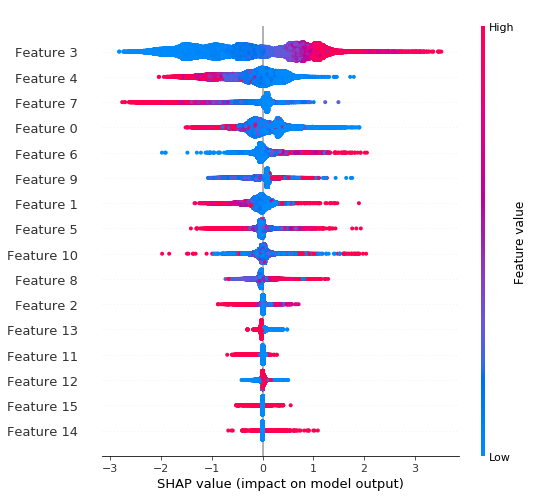

In [95]:
clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric = 'logloss', random_state = 1)
clf.fit(X_train, y_train)

explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train)